# Lekce 10

Rozhodovací stromy jou dalším z algoritmů, které můžeme používat ke klasifikaci. Jejich obrovskou výhodou je, že jsou velmi snadno interpretovatelné. To znamená, že uživatel může snadno zjistit, proč algoritmus přiřadil záznam k dané skupině.

Scikit-learn umí graf exportovat ve formátu aplikace Graphviz. Pro ni pak existuje modul, který umí vykreslit rozhodovací strom jak obrázek.

- Nejprve je potřeba stáhnout software Graphviz [zde](https://graphviz.org/download/).
- Následně je potřeba nainstalovat modul `pydotplus` příkazem `pip install pydotplus`.

In [85]:
import pandas
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from pydotplus import graph_from_dot_data

Budeme pracovat s daty v souboru [titanic.csv](titanic.csv), která obsahují data o pasažérech Titanicu. Náš model bude predikovat, jestli pasažér(ka) potopení Titanicu přežil(a).

In [86]:
data = pandas.read_csv("titanic.csv")
data.head()

,sex,age,sibsp,parch,fare,embarked,class,who,alone,survived
0,male,22.0,1,0,7.2500,S,Third,man,False,0
1,female,38.0,1,0,71.2833,C,First,woman,False,1
2,female,26.0,0,0,7.9250,S,Third,woman,True,1
3,female,35.0,1,0,53.1000,S,First,woman,False,1
4,male,35.0,0,0,8.0500,S,Third,man,True,0


Aby náš první strom byl co nejjenodušší, budeme pasažéry rozdělovat pouze podle pohlaví. Do tabulky `X` tedy vložíme pouze sloupec `sex` a do série `y` sloupec `survived`.

In [87]:
feature_cols = ["sex"]

X = data[feature_cols]
y = data["survived"]

Rozhodovací strom si sám o sobě neporadí s textovými zápisy pohlaví, využijeme proto `OneHotEncoder`.

In [88]:
encoder = OneHotEncoder()
X = encoder.fit_transform(X)
X = X.toarray()
X

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [89]:
print(X)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


Data si na testovací a trénovací sadu rozdělíme ručně, protože zatím `GridSearchCV`.

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Dále vytvoříme `DecisionTreeClassifier`, což je klasifikátor využívající algoritmus rozhodovacího stromu. Necháme nastavené výchozí parametry.

In [91]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Dále vygenerujeme grafický výstup. Využijeme funkci `export_graphviz`. Abychom si obrázek mohli prohlédnout Jupyter notebooku, využijeme následující příkazy. Výsledkem je obrázek, který se zobrazí v Jupyter notebooku.

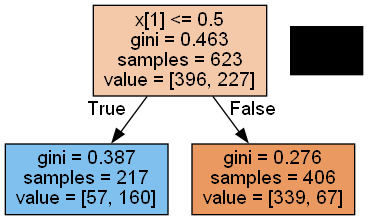

In [92]:
# Vytvoření objektu StringIO, který je jakousi "virtuální" souborovou strukturou v paměti. 
# Tento objekt bude použit pro ukládání struktury rozhodovacího stromu.
dot_data = StringIO()
# Funkce export_graphviz z knihovny sklearn se používá pro konverzi rozhodovacího stromu 
# do DOT formátu, což je grafický jazyk používaný pro popis grafů a stromů. Parametr out_file určuje,
# kam se výsledek uloží - v tomto případě do naší StringIO instance dot_data. Parametr filled=True znamená, 
# že uzly stromu budou vyplněny barvou, což může pomoci vizualizovat hodnoty v uzlech.
export_graphviz(clf, out_file=dot_data, filled=True)
# Tento řádek kódu používá knihovnu pydotplus k převedení DOT dat do formátu, který lze využít pro vytvoření obrázku. 
# Metoda getvalue() naší instance StringIO (dot_data) se používá pro získání celého obsahu jako jednoho řetězce.
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# Tento poslední řádek vytváří obrázek stromu ve formátu PNG. Funkce Image pochází z knihovny IPython 
# a slouží pro zobrazení obrázku přímo v notebooku Jupyter. Metoda create_png() na objektu graph generuje samotný obrázek.
Image(graph.create_png())

Pokud Jupyter notebooku nepoužíváme nebo pokud chceme uložit strom jako obrázek (např. pro vložení do blogového článku), příkaz upravíme. Použijeme metodu `write_png()` a jako parametr zadáme jméno souboru, kam chceme obrázek uložit. Přípona souboru by měla být `.png`, což je oblíbený grafický formát pro ukládání obrázků.

In [93]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')

True

Označení "strom" vychází z části matematiky, která se nazývá teorie grafů. My se jí zabývat nebudeme, ale popíšeme si jeho strukturu a pojmy, které se k jejímu popisu používají.

Nahoře je tzv. vrchol, z něhož vychází dvě hrany. Tento vrchol má dva potomoky. Ti sami už žádné potomky nemají, vrcholy bez potomků pak značujeme jako listy. Každý z vrcholů (kromě listů) je místem, kde se musíme rozhodnout, kterou z hran budeme pokračovat. Rozhodnutí provádíme na základě záznamů, který chceme klasifikovat. V našem případě se rozhodnujeme pouze na základě pohlaví (nic dalšího v datech nemáme). Rozhodujeme se podle prvního řádku popisu uzlu. Zde je ale dost tajemný výraz `X[0] <= 0.5`. Abychom zjistili, co tento výraz znamená, doplnímu do grafu popisku sloupců (`features`) našich dat. Tyto popisky zázkáme od `encoder`, který s nimi manipuloval. Slouží k tomu metoda `get_feature_names_out()`.

In [94]:
encoder.get_feature_names_out()

array(['sex_female', 'sex_male'], dtype=object)

Výsledek volání metody přidáme jako parametr `feature_names` funkci `export_graphviz`.

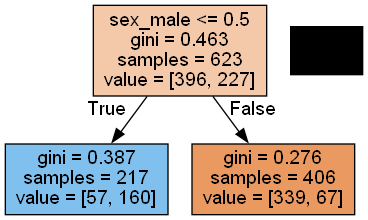

In [95]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=encoder.get_feature_names_out())
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Nyní již vidíme, že v kořenu je `sex_female`. Pokud je v tomto sloupci 0, pak je pasažér muž, pokud je ve sloupci 1, pak je pasažér žena. My bychom chtěli klasifikovat muže, vybíráme tedy variantu `True` (tj. je pravda, že ve sloupci `sex_female` by měl pasažér 0). Další uzel je list, protože nemá potomky. Nyní musíme provést rozhodnutí, do jaké skupiny pasažéra zařadit. Ve druhém řádku listu vidíme, že mužů bylo v trénovacích datech `406` a v posledním řádku dále vidíme `value = [339, 67]`. To jsou počty pozorování dle hodnot výstupní proměnné. Hodnotu 0 výstupní proměnné má 339 (pomět mužů, kteří zahynuli) a hodnotu 1 výstupní proměnné má 67 (počet mužů, kteří přežili). Muže bychom tedy zařadili do skupiny těch, kteří nepřežili.

Přehlednost zobrazení zvýší, pokud doplníme parametr `class_names`. Pak uvidíme třídu, kterou rozhodovací strom predikuje, v posledním řádku.

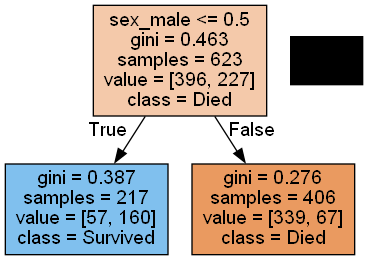

In [96]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=encoder.get_feature_names_out(), class_names=["Died", "Survived"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Nyní do stromu přidáme další proměnou, pomocí které bude strom predikovat, a to třída, ve které každá z osob cestovala. Vidíme, že strom se docela rozrostl.

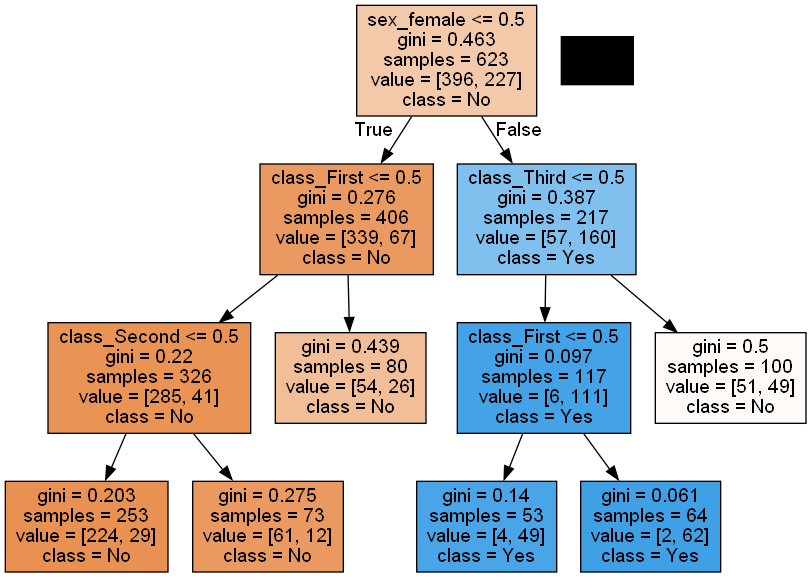

In [97]:
feature_cols = ["sex", "class"]

X = data[feature_cols]
y = data["survived"]

encoder = OneHotEncoder()
X = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=encoder.get_feature_names_out(), class_names=["No", "Yes"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

U rozhodovacího stromu můžeme, podobně jako u ostatních algoritmů, nastavovat parametry. U rozhodovacího stromu můžeme měnit tyto:

- `max_depth` = hloubka stromu ("počet pater" stromu),
- `min_samples_split` = minimální počet vzorků pro rozdělení (pokud bude mít uzel méně, nepůjde dále rozdělit a stane se listem).

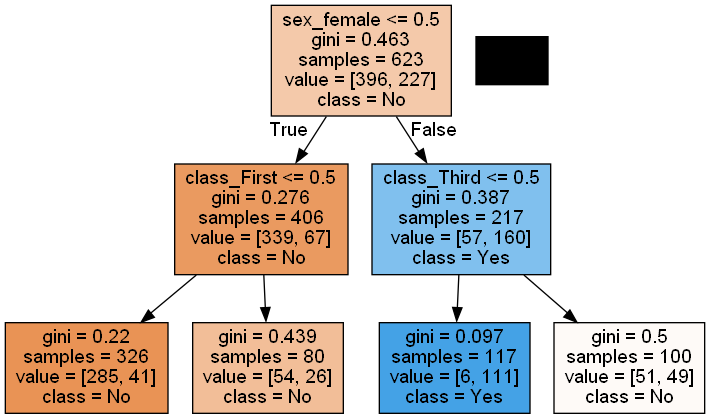

In [98]:
feature_cols = ["sex", "class"]

X = data[feature_cols]
y = data["survived"]

encoder = OneHotEncoder()
X = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Strom může mít maximálně 2 patra (kořen nepočítáme)
clf = DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=encoder.get_feature_names_out(), class_names=["No", "Yes"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

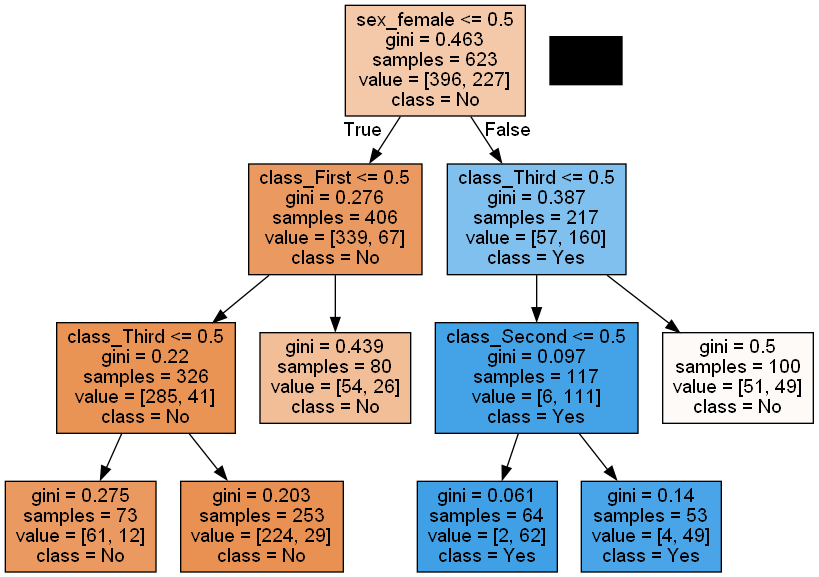

In [99]:
feature_cols = ["sex", "class"]

X = data[feature_cols]
y = data["survived"]

encoder = OneHotEncoder()
X = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Uzly s méně než 100 vzorky již nejdou rozdělit
clf = DecisionTreeClassifier(min_samples_split=100)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=encoder.get_feature_names_out(), class_names=["No", "Yes"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Nyní přidáme další proměnné. Budeme se držet čistě kategoriálních proměnných. Namísto `sex` použijeme `who`, což je sloupec, který rozděluje osoby na muže, ženy a děti. Strom, který tento kód vygeneruje, je opravdu gigantický a určitě by se nám jen nepovedlo například rozumně vytisknout na stránku o velikosti A4. To ale nevadí, řada komplexních dat vede ke komplexnímu rozhodovacímu stromu. Pokud potřebujeme strom menší (např. aby byl více přehledný), můžeme použít parametry, které jsme si ukazovali výše.

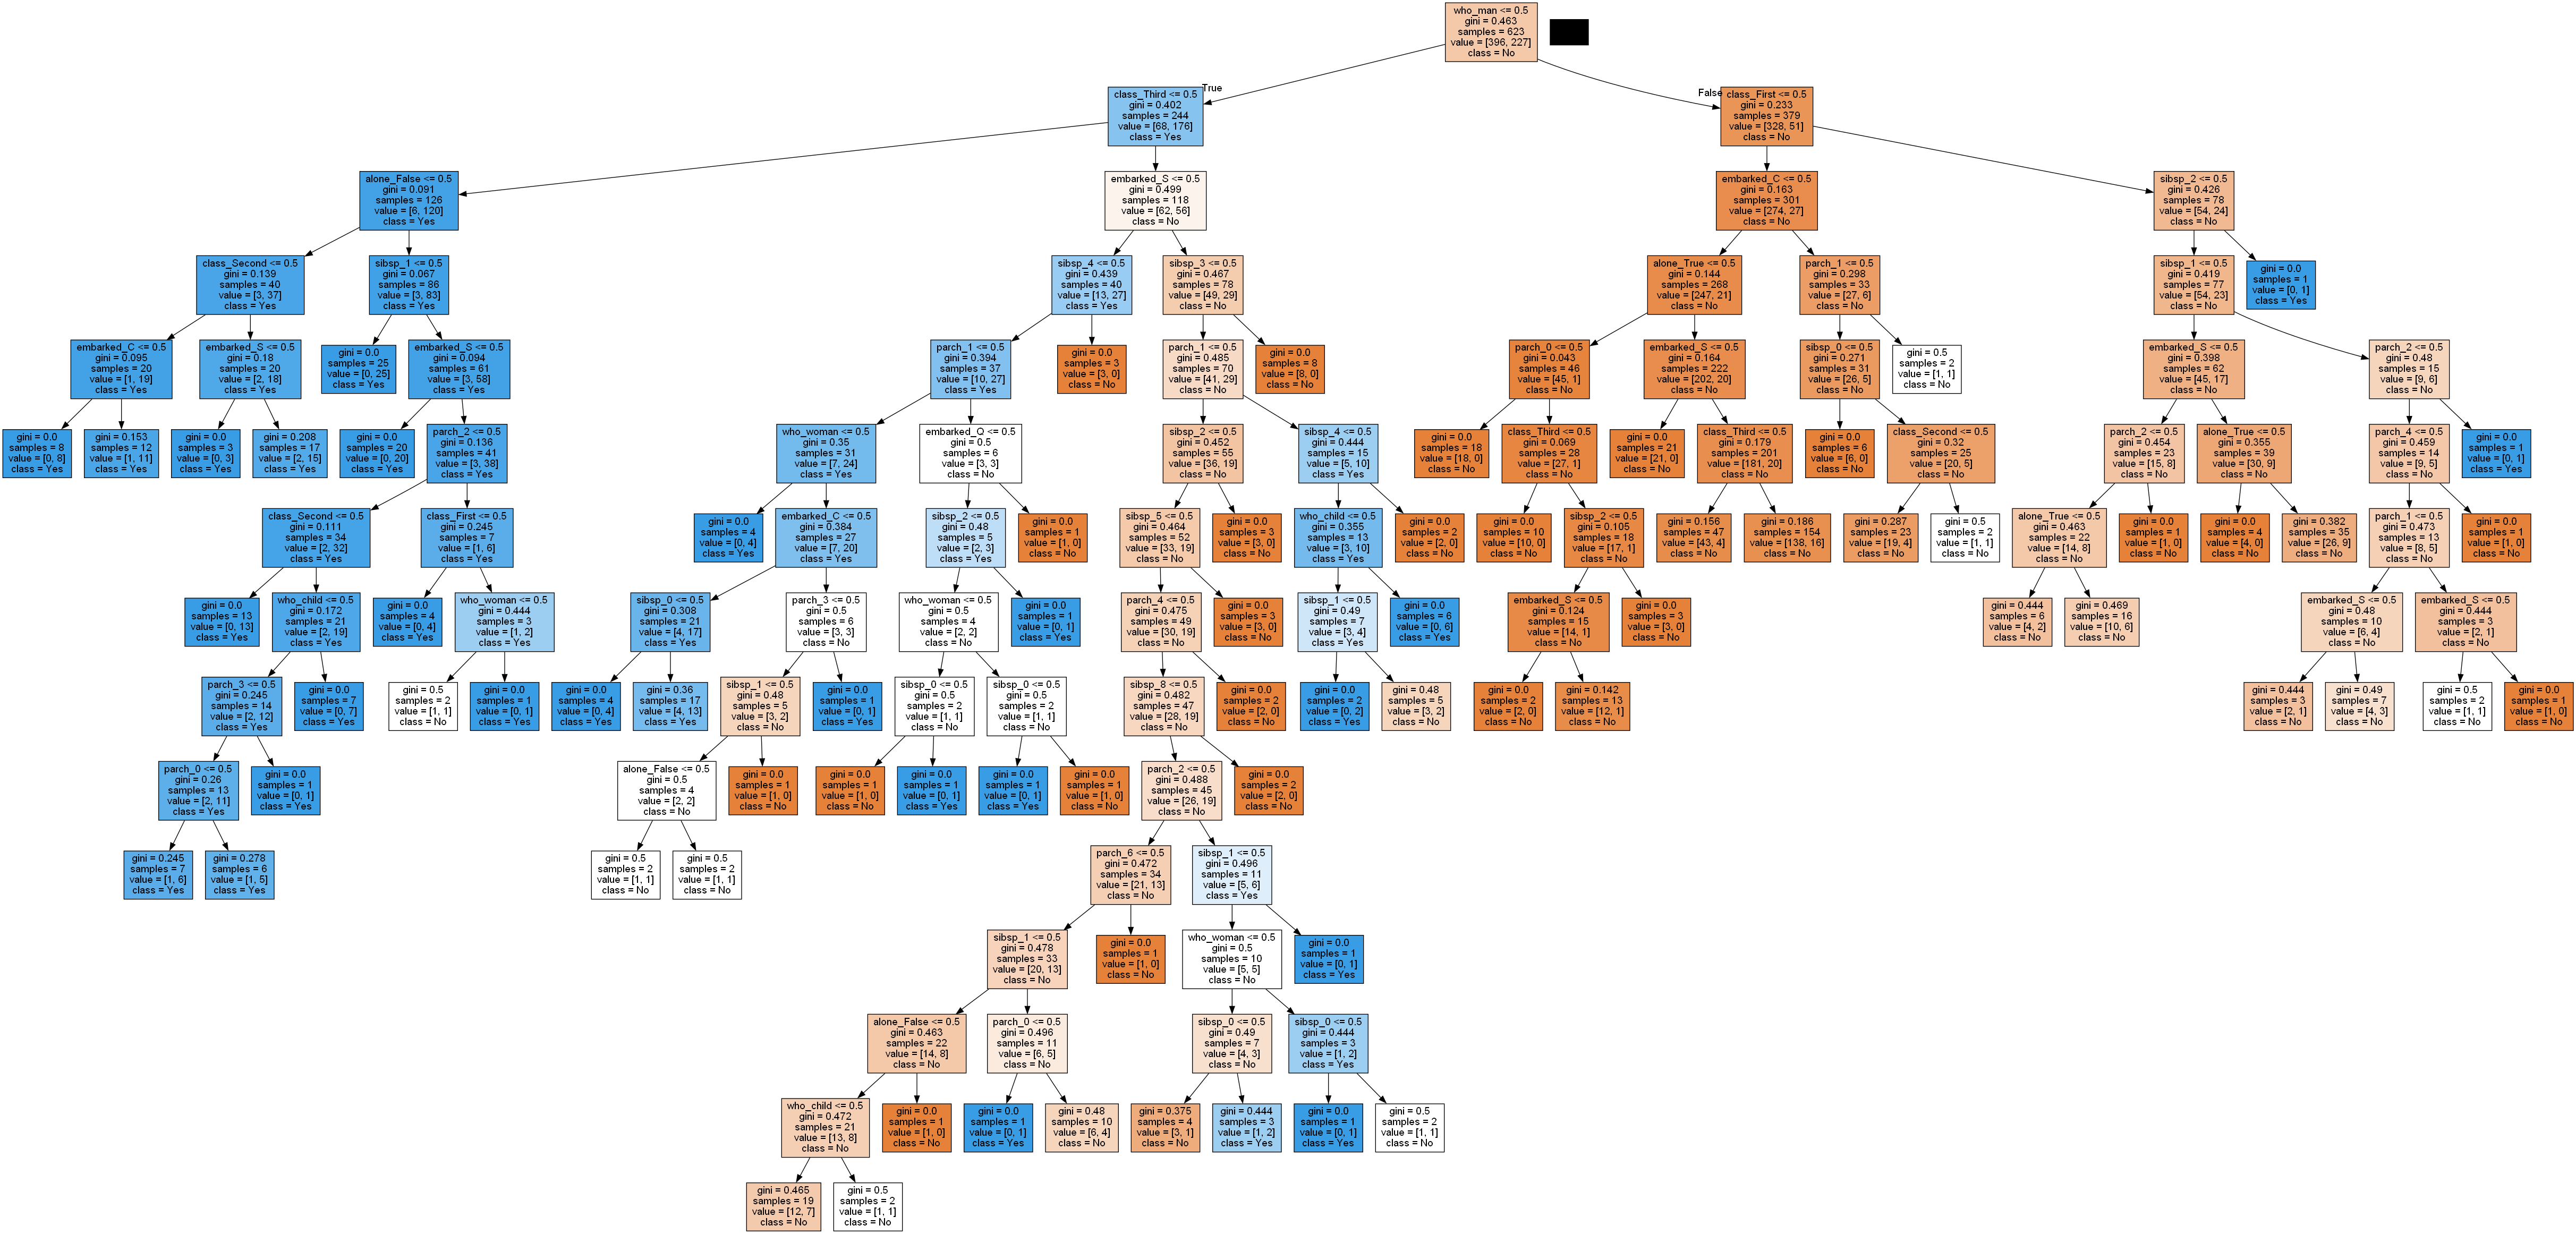

In [100]:
feature_cols = ["sibsp", "parch", "embarked", "class", "who", "alone"]

X = data[feature_cols]
y = data["survived"]

encoder = OneHotEncoder()
X = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=encoder.get_feature_names_out(), class_names=["No", "Yes"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

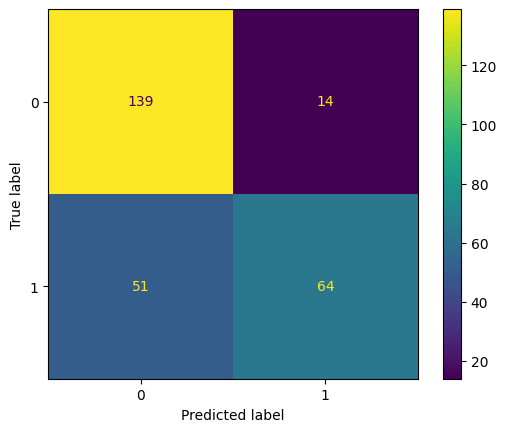

In [101]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,)

In [102]:
import numpy

y = data["survived"]

categorical_columns = ["sibsp", "parch", "embarked", "class", "who", "alone"]
numeric_columns = ["fare"]

ohe = OneHotEncoder()
others = data[numeric_columns].to_numpy()
encoded_columns = ohe.fit_transform(data[categorical_columns])
encoded_columns = encoded_columns.toarray()

X = numpy.concatenate([encoded_columns, others], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Výsledky rozhodovacího stromu můžeme zobrazit pomocí matice záměn. Ta funguje stejně jako u předchozích algoritmů.

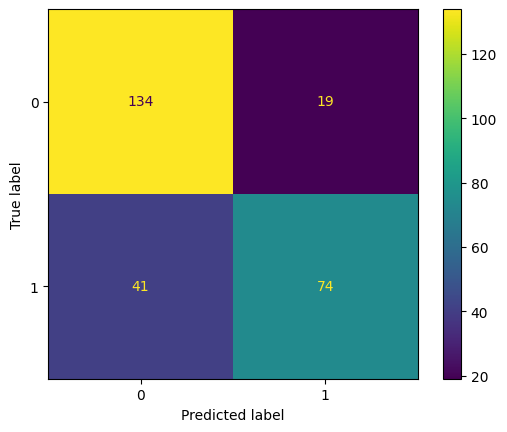

In [103]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

Podobně můžeme určitě i metriky modelu.

In [104]:
accuracy_score(y_test, y_pred)

0.7761194029850746

In [105]:
precision_score(y_test, y_pred)

0.7956989247311828

In [106]:
recall_score(y_test, y_pred)

0.6434782608695652